In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D,MaxPool2D,ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import vgg16
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

#for model deployement 
import os
import cv2
import numpy as np
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import img_to_array

2023-05-30 21:32:08.204911: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('/Users/inseonk/Documents/GDSC/Spring Quarter/fer2013.csv') #read dataset

df.head(5),df.shape  #first five rows and count of rows and columns

(   emotion                                             pixels     Usage
 0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
 1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
 2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
 3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
 4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training,
 (35887, 3))

In [3]:
# Null values present in the file
df.isna().sum().sum()

0

In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [3]:
emotions = { #list of available emotions in the dataset
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprize",
    6:"Neutral"
}

In [4]:
count_emotions = (df.groupby(df['emotion'])['pixels'].count()).to_frame()
count_emotions['emotion name'] = [emotions[k] for k in emotions.keys()]
count_emotions

,pixels,emotion name
emotion,,
0,4953,Angry
1,547,Disgust
2,5121,Fear
3,8989,Happy
4,6077,Sad
5,4002,Surprize
6,6198,Neutral


In [6]:
count_usage = (df.groupby(df['Usage'])['pixels'].count()).to_frame()
count_usage

,pixels
Usage,
PrivateTest,3589
PublicTest,3589
Training,28709


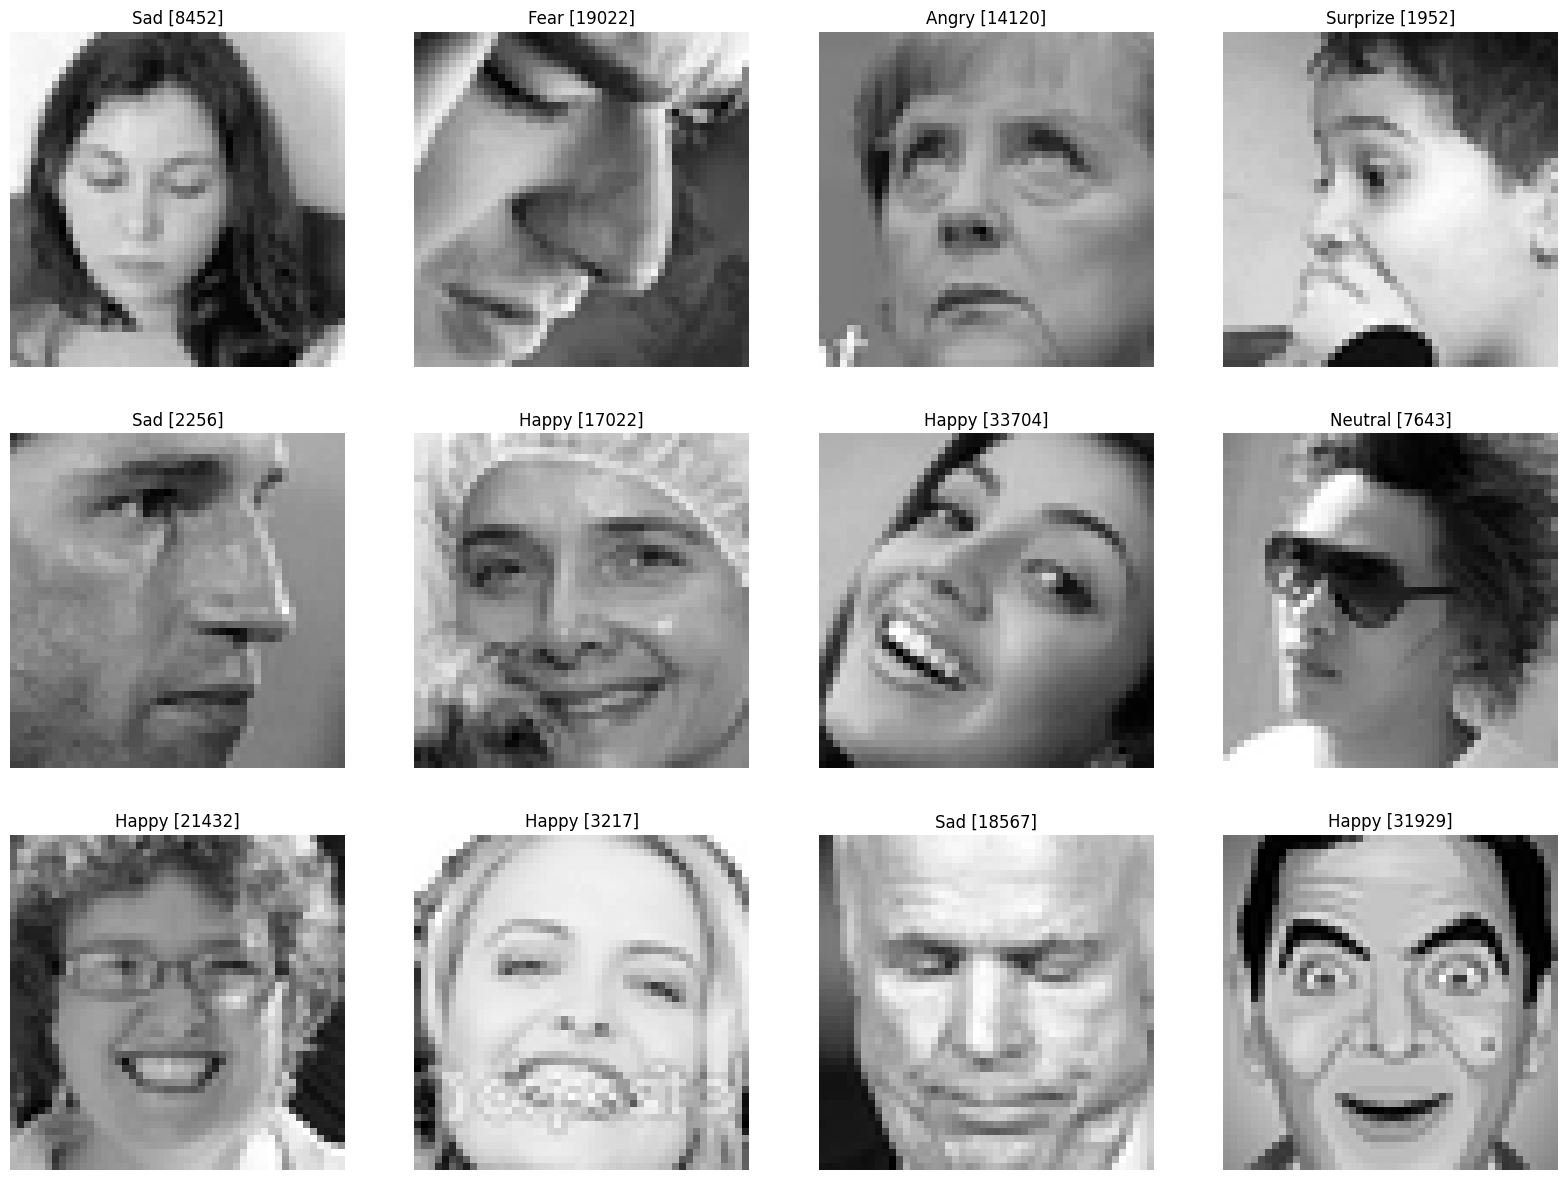

In [4]:
# from PIL import Image
# pixels = df['pixels'][0]
# b = bytes(int(p) for p in pixels.split())
# i = Image.frombuffer('L',(48,48),b)
# di.save('a.png')
def visualize_images(n_img=4):
    indices = np.random.randint(0,df.shape[0],size=n_img)
#     print(indices)
    plt.figure(figsize=(20,20))
    for i,l in zip(indices,range(0,len(indices))):
        image_ar = np.array([i for i in  df['pixels'][i].split()] , dtype='float')
        pixels = np.reshape(image_ar,(48,48))
        ax = plt.subplot(4,4,l+1)
        plt.imshow(pixels,cmap='gray')
        plt.title(emotions[df['emotion'][i]]+" ["+str(i)+"]")
        plt.xticks()
        plt.yticks([])
        plt.axis("off")
visualize_images(12)

In [4]:
X_train,y_train = [],[]
X_val,y_val = [],[]
X_test,y_test = [],[]
for index,row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PrivateTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_val.append(np.array(k))
        y_val.append(row['emotion'])

X_train = np.array(X_train,dtype='float')
y_train = np.array(y_train)
X_test = np.array(X_test,dtype='float')
y_test = np.array(y_test)
X_val = np.array(X_val,dtype='float')
y_val = np.array(y_val)

In [5]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((28709, 2304), (28709,), (3589, 2304), (3589,), (3589, 2304), (3589,))

In [6]:
X_train = X_train.reshape(X_train.shape[0],48,48,1)
X_test = X_test.reshape(X_test.shape[0],48,48,1)
X_val = X_val.reshape(X_val.shape[0],48,48,1)

y_train = to_categorical(y_train,num_classes=7) 
y_test = to_categorical(y_test,num_classes=7)
y_val = to_categorical(y_val,num_classes=7)

X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((28709, 48, 48, 1),
 (28709, 7),
 (3589, 48, 48, 1),
 (3589, 7),
 (3589, 48, 48, 1),
 (3589, 7))

In [7]:
def cnn_model():
  model = Sequential()

  model.add(ZeroPadding2D((1,1),input_shape=(48,48,1),name="block1_pad1"))
  model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l1"))
  model.add(ZeroPadding2D((1,1),name="block1_pad2"))
  model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l2"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool1"))

  model.add(ZeroPadding2D((1,1),name="block2_pad1"))
  model.add(Conv2D(128, (3, 3), activation='relu',name="block2_l1"))
  model.add(ZeroPadding2D((1,1),name="block2_l2"))
  model.add(Conv2D(128, (3, 3), activation='relu',name="block2_pad2"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool2"))

  model.add(ZeroPadding2D((1,1),name="block3_pad1"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l1"))
  model.add(ZeroPadding2D((1,1),name="block3_pad2"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l2"))
  model.add(ZeroPadding2D((1,1),name="block3_pad3"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool3"))

  model.add(ZeroPadding2D((1,1),name="block4_pad1"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l1"))
  model.add(ZeroPadding2D((1,1),name="block4_pad2"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l2"))
  model.add(ZeroPadding2D((1,1),name="block4_pad3"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool4"))


  model.add(ZeroPadding2D((1,1),name="block5_pad1"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l1"))
  model.add(ZeroPadding2D((1,1),name="block5_pad2"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l2"))
  model.add(ZeroPadding2D((1,1), name="block5_pad3"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool5"))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu',name="block6"))
  model.add(Dropout(0.5,name="drop1"))
  model.add(Dense(4096, activation='relu',name="block7"))
  model.add(Dropout(0.5,name="drop2"))
  model.add(Dense(7, activation='softmax',name="block8"))

  return model

In [8]:
model = cnn_model()
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_pad1 (ZeroPadding2D)  (None, 50, 50, 1)        0         
                                                                 
 block1_l1 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 block1_pad2 (ZeroPadding2D)  (None, 50, 50, 64)       0         
                                                                 
 block1_l2 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 24, 24, 64)        0         
                                                                 
 block2_pad1 (ZeroPadding2D)  (None, 26, 26, 64)       0         
                                                                 
 block2_l1 (Conv2D)          (None, 24, 24, 128)       7

In [14]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 10),
                              ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                              save_best_only=True,mode="max")]

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30,
    callbacks=checkpointer,
    validation_data=(X_val,y_val)
)

Epoch 1/30
898/898 [==============================] - ETA: 0s - loss: 1.8247 - accuracy: 0.2465
Epoch 1: val_accuracy improved from -inf to 0.24937, saving model to best_model.h5
898/898 [==============================] - 1086s 1s/step - loss: 1.8247 - accuracy: 0.2465 - val_loss: 1.8342 - val_accuracy: 0.2494
Epoch 2/30
898/898 [==============================] - ETA: 0s - loss: 1.7823 - accuracy: 0.2684
Epoch 2: val_accuracy did not improve from 0.24937
898/898 [==============================] - 1174s 1s/step - loss: 1.7823 - accuracy: 0.2684 - val_loss: 1.8703 - val_accuracy: 0.1819
Epoch 3/30
898/898 [==============================] - ETA: 0s - loss: 1.6214 - accuracy: 0.3627
Epoch 3: val_accuracy improved from 0.24937 to 0.31290, saving model to best_model.h5
898/898 [==============================] - 1250s 1s/step - loss: 1.6214 - accuracy: 0.3627 - val_loss: 1.7934 - val_accuracy: 0.3129
Epoch 4/30
898/898 [==============================] - ETA: 0s - loss: 1.4829 - accuracy: 0.42

Epoch 29/30
898/898 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9778
Epoch 29: val_accuracy did not improve from 0.59710
898/898 [==============================] - 1011s 1s/step - loss: 0.0735 - accuracy: 0.9778 - val_loss: 2.6750 - val_accuracy: 0.5812
Epoch 30/30
898/898 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.9784
Epoch 30: val_accuracy did not improve from 0.59710
898/898 [==============================] - 1009s 1s/step - loss: 0.0679 - accuracy: 0.9784 - val_loss: 2.2815 - val_accuracy: 0.5854


## Model Evaluation

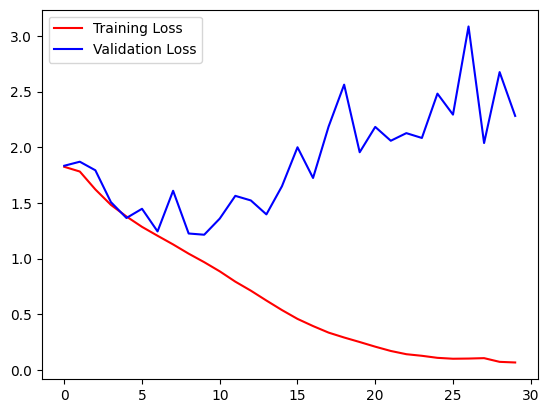

In [15]:
def loss_plot(history):
  plt.plot(history.history["loss"],'r', label="Training Loss")
  plt.plot(history.history["val_loss"],'b', label="Validation Loss")
  plt.legend()

loss_plot(history)

In [16]:
# Model Inference
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 [==============================] - 25s 214ms/step


In [13]:
#function to plot images with their lables(actual vs predicted)
def check_images(X_test,y_pred,label_dict={}):

  figure = plt.figure(figsize=(20, 8))
  for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
      ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(X_test[index]),cmap="gray")
      predict_index = label_dict[(y_pred[index])]
      true_index = label_dict[np.argmax(y_test,axis=1)[index]]
      
      ax.set_title("{} ({})".format((predict_index), 
                                    (true_index)),
                                    color=("green" if predict_index == true_index else "red"))
check_images(X_test,y_pred,emotions)

NameError: name 'y_pred' is not defined

In [ ]:
 # loss and accuracy
loss_and_metrics = model.evaluate(X_train,y_train)
print("On Training Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_val,y_val)
print("On Validation Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_test,y_test)
print("On Test Data",loss_and_metrics)

## Model Saving

In [9]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
# model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## OpenCV with webcam

In [10]:
model = model_from_json(open("model.json", "r").read())
model.load_weights('best_model.h5')
face_haar_cascade = cv2.CascadeClassifier('/Users/inseonk/Documents/GDSC/Spring Quarter/haarcascade_frontalface_default.xml')

In [11]:
# import modules for text-to-speech conversation and audio playback
import gtts
from playsound import playsound
import os

In [12]:
cap=cv2.VideoCapture(0) # start webcam
while True:
    (valid,test_image)=cap.read() #reading image from video frame
    if not valid: #if not getting frames then exit
        break

    gray_image= cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY) #converting the rgb image to grayscale


    faces_detected = face_haar_cascade.detectMultiScale(gray_image) #detecting faces from the image using haar_cascade
    for (x,y,w,h) in faces_detected: #cordinates of deteced faces
        cv2.rectangle(gray_image,(x,y), (x+w,y+h), (255,0,0)) #putting a rectange box around detected face
        roi_gray=gray_image[y:y+w,x:x+h]  # capturing only face from the image
        roi_gray=cv2.resize(roi_gray,(48,48)) # resizing it to 48,48 (that's what mdodel wants as an input)
        image_pixels = img_to_array(roi_gray) #converting image to array
        image_pixels = np.expand_dims(image_pixels, axis = 0) #expanding dims as model needs input in batches
        # image_pixels /= 255


        predictions = model.predict(image_pixels) #model prediction
        max_index = np.argmax(predictions[0]) #getting emotion index

        emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        emotion_prediction = emotion_detection[max_index]

        cv2.putText(test_image, emotion_prediction, (int(x), int(y)),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3) #putting text around face
    #   cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)  
    
        mytext = "You are" + emotion_prediction
        language = 'en'
        
        tts = gtts.gTTS(mytext)
        tts.save("face_emotion.mp3")
        playsound("face_emotion.mp3")

        resize_image = cv2.resize(test_image, (1000, 700)) #enhancing the image to display
        cv2.imshow('Emotion Dectector',resize_image)
        if cv2.waitKey(10) == ord('b'):
            break
cap.release()
cv2.destroyAllWindows

1/1 [==============================] - 0s 44ms/step


KeyboardInterrupt: 